# Recommender Systems - Mini Challenge FS24

In this minichallenge we will explore a MovieLens dataset and implement several recommender systems and evaluation methods. Subsequently we will optimize these methods and compare the results. 

**Submission deadline:** 5.5.2024 23:59. 

## Guidelines for Implementation and Submission
- Code must be written in Python or R. The versions of all used packages must be given for reproducability.
- We develop numerous algorithms ourselves. Unless explicitly stated otherwise, only the following libraries may be used in Python: numpy, matplotlib, seaborn, pandas. In R only the base package, ggplot2, lattice, dplyr. 
- Follow good coding practices and write modular, reusable code.
- The submitted solution must contain all codes and the results. No code may be outsourced.
- If computation time is too long for productive prototyping and debugging work, it is recommended to reduce the dataset to a fraction of its original. However, final results should be calculated on the full dataset. 
- All plots must be fully labeled (title, axes, labels, colorbar, etc.) so that the plot can be easily understood.
- Each plot should be accompanied by a brief discussion, which explains the plot and captures the key insights that become visible.
- Only fully labeled plots with an accompanying discussion will be assessed.
- The last commit in your fork of the repo before the submission deadline counts as the submission.
- If you would like to submit and have the mini-challenge assessed, please send a short email to the subject expert (moritz.kirschmann@fhnw.ch) within 2 days after submission.
- Please do not delete, duplicate, or move the existing cells. This leads to problems during the correction. However, you may add as many additional cells as you like.

## Exercises

### Exercise 1 - A deep exploration of the dataset (17 points)
We will work with a subset of the MovieLens dataset. This subset is located under ``data/ml-latest-small``. Read the ``README.txt``carefully. 
Open the files. 
Create usefull data representations such as the the *User Item Matrix*.
Perform explorative data analysis. Describe the available data. Did you find duplicates or otherwise bad data? 

Generate lists of
- Top 20 movies by average rating
- Top 20 movies by number of views

Answer: 
- What is the range of the ratings? 
- Which genre has be rated how many times?
- How sparse is the User Rating Matrix?

Plot the following:
- How many users have rated how many movies
- Which rating is given how often on average
- Which rating is given how often on average per genre
- The rating distributions of 10 random movies
- The rating distributions of 3 movies that you have watched
- How many users give which average rating
- How often a movie was rated as a function of average rating
- A heatmap of the User Item Matrix
- A heatmap of the User Item Matrix for the 100 most rated movies for the 50 users with most ratings


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATA_FOLDER = 'data/ml-latest-small/'

df_movies = pd.read_csv(DATA_FOLDER + 'movies.csv')
df_ratings = pd.read_csv(DATA_FOLDER + 'ratings.csv')

genres_dummies = df_movies['genres'].str.get_dummies(sep='|')
df_movies['genres_list'] = df_movies['genres'].str.split('|')

df_movies['movieId_seq'] = range(1, len(df_movies) + 1)

genre_dummies = df_movies['genres_list'].str.join('|').str.get_dummies()

df_movies = pd.concat([df_movies, genre_dummies], axis=1)

df_movies = df_movies.drop(columns=['genres', 'genres_list'])

df_movieratings = pd.merge(df_ratings, df_movies, on='movieId')

sns.set_palette('crest')

user_item_matrix = df_movieratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

#### Number of Users and Ratings
How many users have rated how many movies?

In [ ]:
n_movies = df_movies['movieId'].nunique()
n_users = df_ratings['userId'].nunique()
n_rated_movies = df_ratings['movieId'].nunique()

values = [n_rated_movies, n_movies-n_rated_movies, n_users]
percentages = [(100 * value / total if total > 0 else 0) for value, total in zip(values, [n_movies, n_movies, n_users])]

fig, ax = plt.subplots()

bars = ax.bar(['Rated Movies', 'Movies without Ratings', 'Users'],
              values,
              zorder=3)

for bar, value, percentage in zip(bars, values, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, 
            f'{value} ({percentage:.2f}%)', 
            ha='center', va='bottom' if height > 0 else 'top')

ax.grid(True, zorder=0)
ax.set_ylabel('Frequency (log scale)')
ax.set_title('Number of Users and Rated Movies')
ax.set_yscale('log')

plt.show()

#### Rating Averages
Which rating is given how often on average?

In [ ]:
df_ratings['rating'].mean()

In [ ]:
rating_counts = df_ratings['rating'].value_counts().sort_index()

fig, ax = plt.subplots()
rating_counts.plot(kind='bar', ax=ax, edgecolor='black')

mean_rating = df_ratings['rating'].mean()
median_rating = df_ratings['rating'].median()

fig.suptitle('Frequency of Each Rating')
ax.set_title(f'Mean Rating: {mean_rating:.2f}, Median Rating: {median_rating:.2f}', fontsize=10)
ax.set_xlabel('Rating')
ax.set_ylabel('Frequency')
ax.grid(axis='y', linestyle='--')

plt.show()

#### Rating Averages per Genre
Which rating is given how often on average per genre?

In [ ]:
genres = df_movieratings.columns[7:]

plt.figure(figsize=(20, 15))
n_rows = len(genres) // 3 + (len(genres) % 3 > 0) + 1  # Added 1 for the "No Genres Listed" plot
n_cols = 3

for i, genre in enumerate(genres, start=1):
    plt.subplot(n_rows, n_cols, i)
    genre_ratings = df_movieratings[df_movieratings[genre] == 1]['rating']
    rating_counts = genre_ratings.value_counts().sort_index()

    if not rating_counts.empty:
        rating_counts.plot(kind='bar', edgecolor='black', zorder=3)
        plt.title(genre)
        plt.xlabel('Rating')
        plt.ylabel('Frequency')
    else:
        plt.title(genre + " (No Ratings)")
    plt.grid(axis='y', linestyle='--', zorder=0)

plt.subplot(n_rows, n_cols, len(genres) + 1)
no_genres_mask = df_movieratings[genres].sum(axis=1) == 0
no_genre_ratings = df_movieratings[no_genres_mask]['rating']
no_genre_rating_counts = no_genre_ratings.value_counts().sort_index()

no_genre_rating_counts.plot(kind='bar', edgecolor='black', zorder=3)
plt.title("No Genres Listed")
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.grid(axis='y', linestyle='--', zorder=0)

plt.tight_layout()
plt.show()

#### Rating Distributions of 10 Random Movies
The rating distributions of 10 random movies?

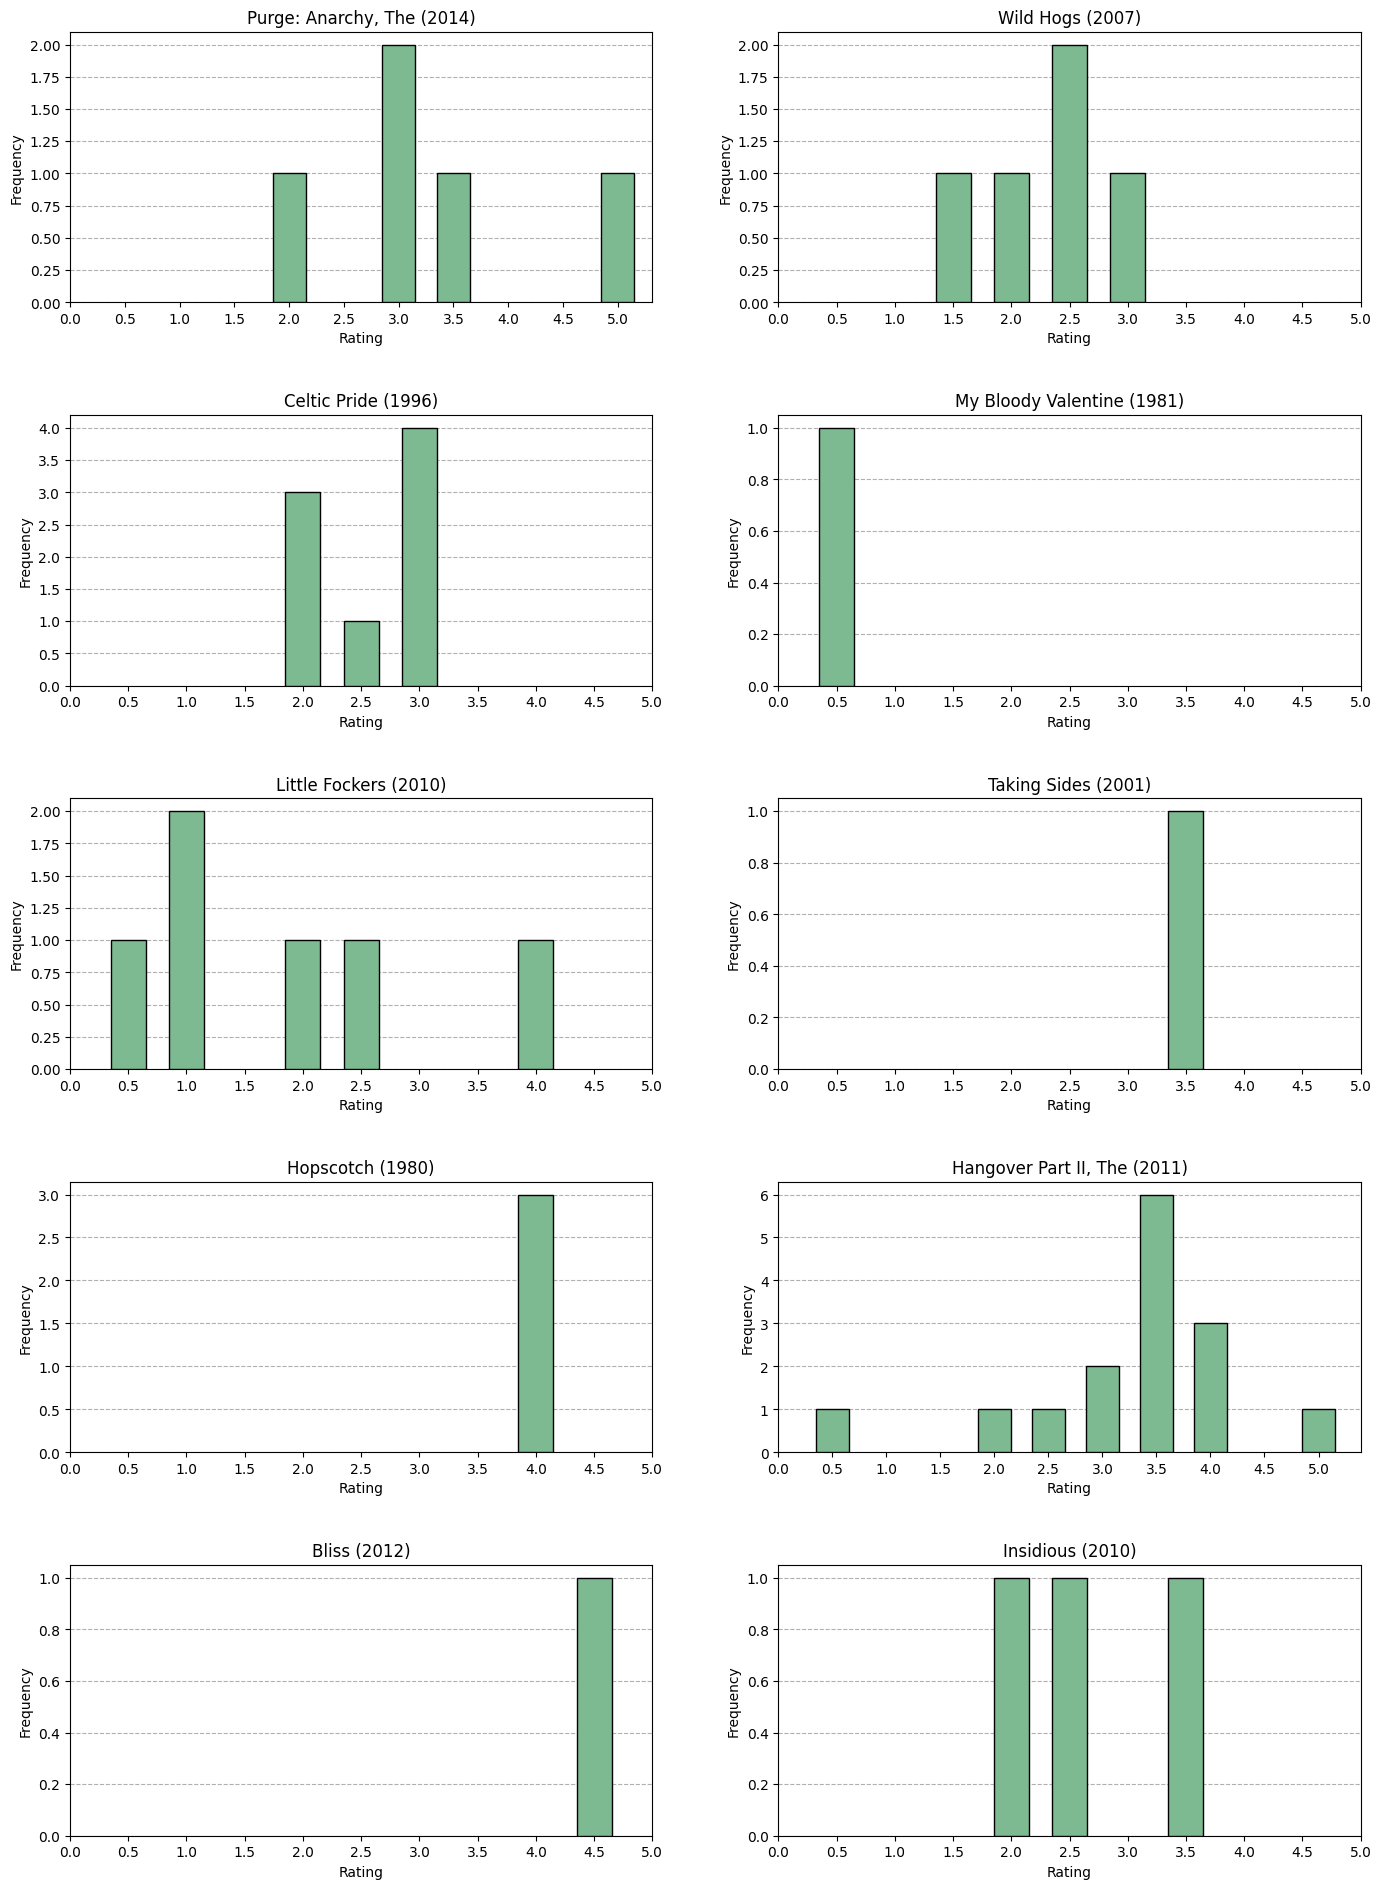

In [22]:
np.random.seed(1337)

sampled_movies = df_movieratings['movieId'].drop_duplicates().sample(n=10, random_state=1)

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
fig.tight_layout(pad=6.0)

axes = axes.flatten()

for i, movieId in enumerate(sampled_movies):
    movie_ratings = df_movieratings[df_movieratings['movieId'] == movieId]['rating']
    rating_counts = movie_ratings.value_counts().sort_index()
    
    axes[i].bar(rating_counts.index, rating_counts.values, edgecolor='black', zorder=3, width=0.3)
    movie_title = df_movieratings.loc[df_movieratings['movieId'] == movieId, 'title'].iloc[0]
    axes[i].set_title(movie_title)
    axes[i].set_xlabel('Rating')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xticks(np.arange(0, 5.5, 0.5))
    
    axes[i].grid(axis='y', linestyle='--', zorder=0)

for ax in axes[i+1:]:
    ax.axis('off')

plt.show()

#### Rating Distributions of 3 Movies I have watched
The rating distributions of 3 movies that you have watched

In [ ]:
my_movies = ['American Psycho (2000)',
             'Blade Runner 2049 (2017)',
             'Wolf of Wall Street, The (2013)']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
fig.tight_layout(pad=6.0)

for i, movie_title in enumerate(my_movies):
    movie_ratings = df_movieratings[df_movieratings['title'] == movie_title]['rating']
    rating_counts = movie_ratings.value_counts().sort_index()
    
    axes[i].bar(rating_counts.index, rating_counts.values, edgecolor='black', zorder=3, width=0.3)
    axes[i].set_title(movie_title)
    axes[i].set_xlabel('Rating')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xticks(np.arange(0, 5.5, 0.5))
    
    axes[i].grid(axis='y', linestyle='--', zorder=0)
    
plt.show()

#### Number of Users per Average Rating
How many users give which average rating?

In [ ]:
user_avg_ratings = df_movieratings.groupby('userId')['rating'].mean().reset_index(name='avg_rating')

user_avg_ratings['avg_rating_rounded'] = user_avg_ratings['avg_rating'].round(1)

avg_rating_counts = user_avg_ratings['avg_rating_rounded'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
avg_rating_counts.plot(kind='bar', zorder=3)
plt.title('Number of Users by Average Rating Given')
plt.xlabel('Average Rating (Rounded)')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', zorder=0)
plt.show()

#### Number of Movie Ratings as a function of Average Rating
How often a movie was rated as a function of average rating

In [ ]:
movie_stats = df_movieratings.groupby('movieId').agg(
    avg_rating=('rating', 'mean'),
    rating_count=('rating', 'count')
).reset_index()

plt.figure(figsize=(10, 6))
plt.scatter(movie_stats['avg_rating'], movie_stats['rating_count'], alpha=0.1)
plt.title('Movie Rating Frequency vs. Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Number of Ratings (Frequency)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

#### User Item Matrix (UIM)
A heatmap of the User Item Matrix

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(user_item_matrix)
plt.title('User-Item Matrix')
plt.xlabel('Movie ID')
plt.ylabel('User ID')
plt.show()

#### User Item Matrix (UIM) for the 100 Most Rated movies for the 50 Users with most Ratings
A heatmap of the User Item Matrix for the 100 most rated movies for the 50 users with most ratings

In [ ]:
n_most_rated = 100
n_most_rated_users = 50

most_rated_movies = df_movieratings['movieId'].value_counts().head(n_most_rated).index
most_rated_users = df_movieratings['userId'].value_counts().head(n_most_rated_users).index

df_most_rated = df_movieratings[
    df_movieratings['movieId'].isin(most_rated_movies) &
    df_movieratings['userId'].isin(most_rated_users)
]

df_most_rated_features = df_most_rated.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

plt.figure(figsize=(10, 10))
sns.heatmap(df_most_rated_features)
plt.title('User-Item Matrix (Most Rated Movies and Users)')
plt.xlabel('Movie ID')
plt.ylabel('User ID')
plt.show()

### Exercise 2 - Building a baseline RS (7 points)
In this exercise we will build a baseline RS and functions to calculate fundamental performance metrics. 

Build the following baseline RS to predict Top-N (default N=20):
1. In reference to the book *Collaborative Filtering Recommender Systems by Michael D. Ekstrand, John T. Riedl and Joseph A. Konstan* (p. 91ff) implement the baseline predictor $$ b_{u,i}= \mu +b_u +b_i $$ with the regularized user and item average offsets: $$ b_u = \frac{1}{|I_u| + \beta_u} \sum_{i \in I_u} (r_{u,i} - \mu) $$ and $$ b_i = \frac{1}{|U_i| + \beta_i} \sum_{u \in U_i} (r_{u,i} - b_u - \mu) . $$ Build a recommender system upon this baseline predictor. Set the default damping factors $\beta_u$ and $\beta_i$ both to 20.
2. Build a RS that recommends based on *random* recommendations.  

Output the recommendations for three example users of your choice. Can you find a user that represents your taste? 

#### Baseline Recommender System

In [23]:
from sklearn.base import BaseEstimator, RegressorMixin

class BaselineRecommender(BaseEstimator, RegressorMixin):
    def __init__(self, beta_u=20, beta_i=20, top_n=20):
        self.beta_u = beta_u
        self.beta_i = beta_i
        self.top_n = top_n

    def fit(self, X, y=None):
        self.X_ = X.copy()
        self.global_mean_ = np.nansum(self.X_.flatten())/np.sum(~np.isnan(self.X_))
        
        self.I_u = np.sum(~np.isnan(self.X_), axis=1)
        self.U_i = np.sum(~np.isnan(self.X_), axis=0)
        
        self.b_u = (np.nansum(self.X_ - self.global_mean_, axis=1)) / (self.I_u + self.beta_u)
        self.b_i = (np.nansum(self.X_ - self.b_u.reshape(-1, 1) - self.global_mean_, axis=0)) / (self.U_i + self.beta_i)
        
        return self
    
    def predict(self, user_id=None, movie_id=None):
        b_u = self.b_u[user_id - 1] if user_id is not None else 0
        b_i = self.b_i[movie_id - 1]
        pred_rating = self.global_mean_ + b_u + b_i
        return pred_rating
    
    def predict_all(self, X):
        pred_ratings = self.global_mean_ + self.b_u.reshape(-1, 1) + self.b_i
        return pred_ratings
    
    def recommend(self, user_id, X):
        user_ratings = self.X_[user_id - 1]
        unrated_movies = np.isnan(user_ratings)
        
        # indices of positions in unrated_movies that are true
        unrated_movie_indices = np.where(unrated_movies)[0]
        
        recommendations = []
        for unrated_movie in unrated_movie_indices:
            pred_rating = self.predict(user_id, unrated_movie + 1)
            recommendations.append((unrated_movie + 1, pred_rating))
        
        # sort recommendations by predicted rating
        recommendations.sort(key=lambda x: x[1], reverse=True)
        
        return recommendations[:self.top_n]


#### Random Recommender System

In [25]:
class RandomRecommender:
    def __init__(self, top_n=20, random_state=1337):
        self.top_n = top_n
        self.random_state = random_state
        self.rng = np.random.default_rng(random_state)

    def fit(self, X):
        self.X_ = X
        return self

    def recommend(self):
        return self.rng.choice(self.X_.shape[1], self.top_n, replace=False)

#### Recommending to three random users

In [50]:
np.random.seed(1337)

baseline_recommender = BaselineRecommender(beta_u=20, beta_i=20, top_n=5)
random_recommender = RandomRecommender(top_n=5, random_state=1337)

baseline_recommender.fit(user_item_matrix.values)
random_recommender.fit(user_item_matrix.values)

user_ids = np.random.choice(user_item_matrix.shape[0], 3)

print("Baseline Recommender:\n")
for user in user_ids:
    rec_movies = baseline_recommender.recommend(user, user_item_matrix.values)
    print(f"User {user} Recommendations:")
    for movie in rec_movies:
        movie_title = df_movies.loc[df_movies['movieId_seq'] == movie[0]]['title'].values[0]
        print(f"- {movie_title}")
    print()
              
print("Random Recommender:\n")
for user in user_ids:
    rand_movies = random_recommender.recommend()
    print(f"User {user} Recommendations:")
    for movie in rand_movies:
        movie_title = df_movies.loc[df_movies['movieId_seq'] == movie]['title'].values[0]
        print(f"- {movie_title}")
    print()
              

Baseline Recommender:

User 151 Recommendations:
- Shawshank Redemption, The (1994)
- Usual Suspects, The (1995)
- Godfather, The (1972)
- Home Alone 2: Lost in New York (1992)
- Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)

User 189 Recommendations:
- Usual Suspects, The (1995)
- Godfather, The (1972)
- Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
- Star Wars: Episode IV - A New Hope (1977)
- Star Wars: Episode V - The Empire Strikes Back (1980)

User 232 Recommendations:
- Usual Suspects, The (1995)
- Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
- 12 Angry Men (1957)
- To Kill a Mockingbird (1962)
- Rear Window (1954)

Random Recommender:

User 151 Recommendations:
- Rambo: First Blood Part II (1985)
- Harold and Kumar Go to White Castle (2004)
- Whatever Works (2009)
- Ward 13 (2003)
- Farmer's Daughter, The (1947)

User 189 Recommendations:
- Flipper (1996)
- Donnie Brasco (1997)
- October 

### Exercise 3 - Evaluation methods (8 points)

Implement a function to partition your dataset for an offline evaluation based on holding out of random users with 5x cross validation. *Use this for all further exercises*
Explain your considerations.

Implement functions to calculate the following metrics:
- *Mean Absolute Error (MAE)* 
- *Root Mean Square Error (RMSE)*
- *Precision@N* with default $N=15$ and relevance threshold 3.5 stars.
- *Recall@N* with default $N=15$ and relevance threshold 3.5 stars.

Explain each of these.

Note: For the last two see https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54. 

In [13]:
class KFold:
    def __init__(self, n_splits=5, random_state=None, shuffle=True, n_hold_out=None):
        self.n_splits = n_splits
        self.random_state = random_state
        self.shuffle = shuffle

    def split(self, data):
        n_samples = len(data)
        indices = np.arange(n_samples)

        if self.shuffle:
            rng = np.random.default_rng(self.random_state)
            rng.shuffle(indices)

        fold_sizes = np.full(self.n_splits, n_samples // self.n_splits, dtype=int)
        fold_sizes[:n_samples % self.n_splits] += 1

        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            test_indices = indices[start:stop]
            train_indices = np.concatenate([indices[:start], indices[stop:]])
            yield train_indices, test_indices
            current = stop

In [14]:
def mean_absolute_error(predictions, actuals):
    return np.mean(np.abs(predictions - actuals))

def root_mean_squared_error(predictions, actuals):
    return np.sqrt(np.mean((predictions - actuals) ** 2))

def precision_at_k(predicted_ratings, actual_ratings, k=15, threshold=3.5):
    if len(predicted_ratings) < k:
        k = len(predicted_ratings)

    top_k_indices = np.argsort(predicted_ratings)[-k:]
    
    relevant_actuals = actual_ratings[top_k_indices] >= threshold
    
    precision = np.mean(relevant_actuals)
    return precision

def recall_at_k(predicted_ratings, actual_ratings, k=15, threshold=3.5):
    if len(predicted_ratings) < k:
        k = len(predicted_ratings)

    top_k_indices = np.argsort(predicted_ratings)[-k:]
    
    relevant_actuals = actual_ratings >= threshold
    relevant_actual_count = np.sum(relevant_actuals)
    
    relevant_in_top_k = relevant_actuals[top_k_indices]
    
    recall = np.sum(relevant_in_top_k) / relevant_actual_count if relevant_actual_count > 0 else 0
    return recall

#### Considerations
The function `partition_data` randomly shuffles the users, divides them into segments according to the number of folds (`n_splits`), and then iteratively uses each segment as a test set while the remaining data form the training set. The process therefore makes sure every user only exists once in the testset, mirroring the K-Fold strategy typically used in machine learning but at a user level, which is particularly useful for recommender systems to evaluate generalization across different users.

### Exercise 4 - Optimize hyperparameters of baseline RS (4 points)
Optimize the hyperparameters $\beta_u$ and $\beta_i$ for the baseline RS from exercise 2 using the RMSE metric. You can use the `GridSearchCV` class from scikit-learn to perform the grid search. To save computation time find a reasonable maximum value for the betas. Explain your approach and your solution.
Plot the RMSE as a function of the betas and output all metrics implemented in exercise 3 achieved at the best RMSE value.

In [18]:
def grid_search_cv(X, beta_u_values, beta_i_values, n_splits=5):
    from sklearn.model_selection import KFold
    import numpy as np

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1337)
    best_rmse = np.inf
    best_params = None

    rmses = []

    for beta_u in beta_u_values:
        for beta_i in beta_i_values:
            cv_rmses = []
            for train_idx, test_idx in kf.split(X):
                X_train, X_test = X[train_idx], X[test_idx]

                base_rs = BaselineRecommender(beta_u=beta_u, beta_i=beta_i)
                base_rs.fit(X_train)

                predictions = np.array([base_rs.predict(movie_id=item_id) for item_id in range(1, X_test.shape[1] + 1)])

                se = np.square(predictions - X_test)

                rmse = np.sqrt(np.nanmean(se))
                cv_rmses.append(rmse)

            avg_rmse = np.mean(cv_rmses)
            rmses.append(avg_rmse)

            if avg_rmse < best_rmse:
                best_rmse = avg_rmse
                best_params = (beta_u, beta_i)

    return best_params, best_rmse, rmses

beta_u_values = [1, 5, 10, 15, 20]
beta_i_values = [1, 5, 10, 15, 20]

best_params, best_rmse, rmses = grid_search_cv(user_item_matrix.values, beta_u_values, beta_i_values)

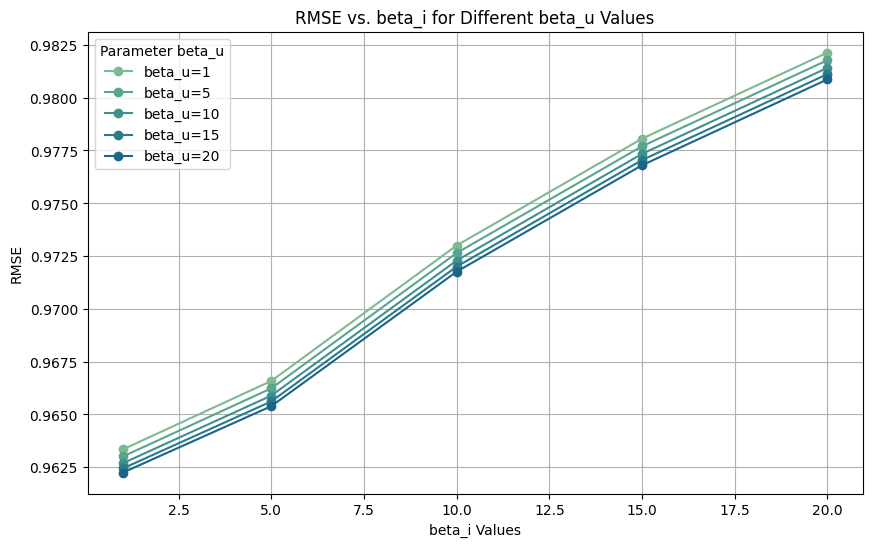

In [19]:
def plot_rmse_hyperparameters(beta_u_values, beta_i_values, rmses):
    rmses_matrix = np.array(rmses).reshape(len(beta_u_values), len(beta_i_values))
    
    plt.figure(figsize=(10, 6))
    for index, beta_u in enumerate(beta_u_values):
        plt.plot(beta_i_values, rmses_matrix[index], label=f'beta_u={beta_u}', marker='o')
    
    plt.title('RMSE vs. beta_i for Different beta_u Values')
    plt.xlabel('beta_i Values')
    plt.ylabel('RMSE')
    plt.legend(title='Parameter beta_u')
    plt.grid(True)
    plt.show()

plot_rmse_hyperparameters(beta_u_values, beta_i_values, rmses)

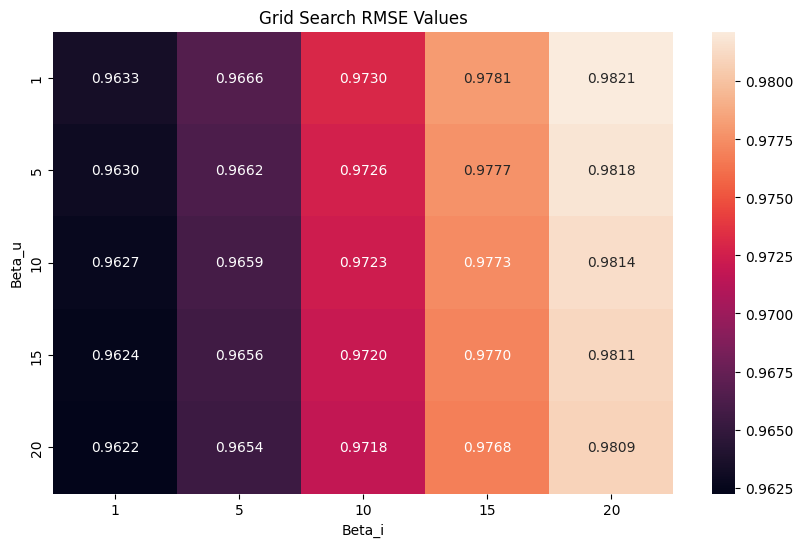

In [20]:
rmses = np.array(rmses).reshape(len(beta_u_values), len(beta_i_values))

plt.figure(figsize=(10, 6))
sns.heatmap(rmses, annot=True, fmt='.4f', xticklabels=beta_i_values, yticklabels=beta_u_values)
plt.title('Grid Search RMSE Values')
plt.xlabel('Beta_i')
plt.ylabel('Beta_u')
plt.show()

In [21]:
best_rmse, best_params

(0.9622451146082394, (20, 1))

### Exercise 5 - Collaborative filtering item based and user based (10 points)
In this exersise we will build several different collaborative-filtering RS based on nearest neighbour technique, both in terms of item and user. 

Implement:
1. a RS based on the $K$ most similar items (K nearest neighbours). Similarity shall be calculated based on *cosine similarity*. 
2. a RS based on the $K$ most similar items (K nearest neighbours). Similarity shall be calculated based on *Pearson Correlation Coefficienct*. 
3. a RS based on the $K$ most similar users (K nearest neighbours). Similarity shall be calculated based on *cosine similarity*. 
4. a RS based on the $K$ most similar users (K nearest neighbours). Similarity shall be calculated based on *Pearson Correlation Coefficienct*. 

Each should have a default $K$ of 30.

Describe the two similarity metrics.


#### Standardizing ratings
An issue is that when trying to calculate similarities (especially cosine similarity) we have certain values in a user's or item's vector that are `np.nan` (no rating). This makes it impossible for a vector to be compared to other vectors. In order to work out a solution to this, I will apply the same approach that was already described in ["Collaborative Filtering Recommender Systems" by Michael Ekstrand](https://spaces.technik.fhnw.ch/storage/uploads/mml/2020/02/collaborativefilteringrecommendersystems.pdf), stating that it is a valid approach to set the Unknown ratings to `0`. 

In [ ]:
user_item_matrix_filled = user_item_matrix.fillna(0)

#### Defining a Base

In [ ]:
class RecommenderSystemBase:
    def __init__(self, K=30):
        self.K = K
        self.similarities = None
        self.ratings_matrix = None

    def _cosine_similarity(self, matrix):
        norm = np.linalg.norm(matrix, axis=1, keepdims=True)
        norm_matrix = matrix / norm
        similarity = np.dot(norm_matrix, norm_matrix.T)
        np.fill_diagonal(similarity, 0)
        return similarity

    def _pearson_correlation(self, matrix):
        mean_centered = matrix - np.mean(matrix, axis=1, keepdims=True)
        corr_matrix = np.corrcoef(mean_centered)
        np.fill_diagonal(corr_matrix, 0)
        return corr_matrix

    def _find_nearest_neighbors(self, idx, exclude_idx=True):
        sorted_indices = np.argsort(-self.similarities[idx])[:self.K+1]
        if exclude_idx:
            sorted_indices = sorted_indices[sorted_indices != idx]
        return sorted_indices[:self.K]

#### K Most Similar Items: Cosine Similarity

In [ ]:
class ItemBasedCF_Cosine(RecommenderSystemBase):
    def fit(self, ratings):
        self.ratings_matrix = ratings
        item_matrix = ratings.T
        self.similarities = self._cosine_similarity(item_matrix)
        self.baseline_recommender = BaselineRecommender()
        
        self.baseline_recommender.fit(ratings)

    def predict(self, user_id, item_id):
        neighbors_idx = self._find_nearest_neighbors(item_id)
        
        p_u_i = np
        
        return neighbors_idx

In [ ]:
item_cf = ItemBasedCF_Cosine(K=30)
item_cf.fit(user_item_matrix_filled.values)

user_id = 1
item_id = 1

item_cf.predict(user_id - 1, item_id - 1)

#### K Most Similar Items: Pearson Correlation Coefficient

In [ ]:
class ItemBasedCF_Pearson(RecommenderSystemBase):
    def fit(self, ratings):
        self.ratings_matrix = ratings
        item_matrix = ratings.T
        self.similarities = self._pearson_correlation(item_matrix)

    def predict(self, user_id, item_id):
        neighbors_idx = self._find_nearest_neighbors(item_id)
        numerator = sum(self.similarities[item_id, neighbor] * self.ratings_matrix[user_id, neighbor] for neighbor in neighbors_idx)
        denominator = sum(abs(self.similarities[item_id, neighbor]) for neighbor in neighbors_idx)
        prediction = numerator / denominator if denominator != 0 else 0
        return prediction

#### K Most Similar Users: Cosine Similarity

In [ ]:
class UserBasedCF_Cosine(RecommenderSystemBase):
    def fit(self, ratings):
        self.ratings_matrix = ratings
        self.similarities = self._cosine_similarity(ratings)

    def predict(self, user_id, item_id):
        neighbors_idx = self._find_nearest_neighbors(user_id)
        numerator = sum(self.similarities[user_id, neighbor] * self.ratings_matrix[neighbor, item_id] for neighbor in neighbors_idx)
        denominator = sum(abs(self.similarities[user_id, neighbor]) for neighbor in neighbors_idx)
        prediction = numerator / denominator if denominator != 0 else 0
        return prediction

#### K Most Similar Users: Pearson Correlation Coefficient

In [ ]:
class UserBasedCF_Pearson(RecommenderSystemBase):
    def fit(self, ratings):
        self.ratings_matrix = ratings
        self.similarities = self._pearson_correlation(ratings)

    def predict(self, user_id, item_id):
        neighbors_idx = self._find_nearest_neighbors(user_id)
        numerator = sum(self.similarities[user_id, neighbor] * self.ratings_matrix[neighbor, item_id] for neighbor in neighbors_idx)
        denominator = sum(abs(self.similarities[user_id, neighbor]) for neighbor in neighbors_idx)
        prediction = numerator / denominator if denominator != 0 else 0
        return prediction

#### Cosine Similarity vs. Pearson Correlation Coefficient

- **Cosine Similarity:** 
- **Pearson Correlation Coefficient:**

### Exercise 6 - Optimize hyperparameter $K$ (6 points)
Optimize the hyperparameter $K$ for all RS from the prior exercise optimizing for minimal RMSE. 
For each RS plot RMSE, Precision@N and Recall@N as a function of $K$. 

Compare the results of these four RS on the 3 example users. Do the results match your expectation? Describe.

In [ ]:
def evaluate_recommender(recommender, X_train, X_test):
    recommender.fit(X_train)
    predictions = np.array([recommender.predict(user_id, item_id) for user_id, item_id in zip(*X_test.nonzero())])
    
    actuals = X_test[X_test.nonzero()]
    
    rmse = calc_root_mean_squared_error(predictions, actuals)
    
    fig, ax = plt.subplots()
    ax.scatter(actuals, predictions, alpha=0.1)
    ax.set_xlabel('Actual Rating')
    ax.set_ylabel('Predicted Rating')
    ax.set_title('Actual vs. Predicted Ratings')
    
evaluate_recommender(ItemBasedCF_Cosine(K=30), user_item_matrix.values, user_item_matrix.values)

### Excercise 7 - Model-based RS: SVD (6 points)
In this exercise we will use the unsupervised method *singular value decomposition (SVD)* from the python package *surprise* (https://surpriselib.com, documentation https://surprise.readthedocs.io/en/stable/matrix_factorization.html) or the R package *recommenderlab*. SVD can compress much of the information of a matrix in few components.  

Run the SVD RS and show the results on the three example users from exercise 2. Explain how this algorithm works.

Note: A very good general introduction to SVD is this youtube video series starting with https://www.youtube.com/watch?v=gXbThCXjZFM&t=337s . See *Collaborative filtering recommender systems* by Ekstrand et al. *Mining of massive datasets* by Leskovec, Kapitel 11 (2020) and ,*Recommender systems: The textbook*, by Aggarwal, chapter 3

#### How SVD works

### Exercise 8 - Optimize hyperparameter $k$ or `n_factors` (4 points)
Optimize the hyperparameter, representing the number of greatest SVD components used for the truncated reconstruction of the user item matrix, to minimize RMSE.
Plot RMSE, Precision@N and Recall@N as a function of this hyperparameter. Finally output all performance metrics from exercise 3 for the found value.

### Exercise 9 - Everything goes (30 points)
In this exercise you can explore different methods of RS. You are not limited what methods you apply. You can try to improve the methods from the earlier exercises by adjusting them or generating ensemble or hybrid RS. Also you can train deep neural networks, use NLP methods, use the available links to imdb available in the dataset to further enrich the dataset or find an obscure method by someone else on Github. However document what your inspirations and sources are and your process. Important: If you use the work of someone else you must be able to explain the method conceptually. 
Output the performance metrics of exercise 3.

**Build and optimize at least three different methods.**

### Exercise 10 - Compare all RS that you build in this challenge (6 points)
Compile a table with the performance metrics of exercise 3 for all RS from this MC (Make sure to include also the baseline RS). Also generate comparative plots. Discuss.

### Exercise 11 - Risks of RS on user or society (5 points)
In this exercise we take one step back from the technical aspects of RS.
Positive effects of good recommendations are easy to imagine: Happy customers and successful companies. However  also come with potential risks. Which risks for the user or society can you imagine or discover online? Pick one risk and describe what you would do to mitigate this problem.

**Read the Guidelines for Implementation and Submission one more time.**